In [1]:
''' Check if we running in google colab'''

REPO_NAME="EP-in-DNN"

try:
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    ! rm -rf "EP-in-DNN"
    ! git clone "https://github.com/kaibrach/EP-in-DNN"
except:
    IN_COLAB = False

%matplotlib inline
from IPython.core.debugger import set_trace
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import logging
import sys
import os
import glob
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import urllib.request
import pandas as pd
import tensorflow as tf

# Import ErrorPropagation Class (see src/ErrorPropagation)
# append the upper directory for importing modules
if IN_COLAB:
    sys.path.append(REPO_NAME)

sys.path.append("..")
import src.ErrorPropagation as ep

tfk = tf.keras

''' Disable Eager Execution for fast execution of the graph'''
#tf.compat.v1.disable_eager_execution()

'''
    Need to import private functions from tensorflow.python.keras instead of tf.keras.backend 
    to get symbolic_learning_phase() to use with K.function an eager execution enabled. 
    Otherwise we will run into an error
    see my entry on https://github.com/tensorflow/tensorflow/issues/34201
'''
from tensorflow.python.keras import backend as K

if not IN_COLAB:
    # suppress annoying Tensorflow warnings
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = '-1' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

    # https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    cpus = tf.config.experimental.list_physical_devices('CPU')

    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    elif cpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            logical_cpus= tf.config.experimental.list_logical_devices('CPU')
            print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
        
K.clear_session()

1 Physical CPU, 1 Logical CPU


# Create CNN Network Dropout Model with Error Propagation

We create a convolutional neural network (CNN) with dropout layers. Supported activation functions are, Linear, ReLU and Softmax. Further we create an object for doing `Error Propagation`.

The class contains the following functions:
* train:  Train the neural network
* predict: Normal prediction without uncertainty information
* predict_mc: MonteCarlo Dropout prediction (mean, variance)
* predict_ep: Prediction of the Error Propagation model (mean, variance)
* model: Getter/Setter property for the trained model
* ep_model: Getter property for the error propagation model 

Predictive Runtime, Entropy, Negative Log Likelihood and Standard Deviation (except normal prediction) is calculated for all predictions mentioned above.

## Error Propagation

Inside of `predict_ep` function an Error Propagation (EP) object is created. The `EP` class is designed for doing error propagation based on a given trained input model (with Dropout). Therefore it creates a new model based on the already trained input model with additional **error** (variance) output. 

If your model contains a layer that is not already part of the EP class, just add a new function with the same "Class-Name" as the layer. For example if you have a layer called `MyCustomLayer` in your model, your function should look like this

```python
def MyCustomLayer(self,error, layer):
    #if error is None: return None
    logging.info(f'Propagate Error {error.shape}')
    ''' Your error propagation implementation '''
```

I implemented a `debug` function that can be used to debug through the code with real values. That helps a lot if you want to check the output of your function (**Hint**: Eager-Execution should be enabled to debug all values in plain numpy). For further information see the example in the class header.

In [2]:
l2 = tfk.regularizers.l2
Input = tfk.layers.Input
Dropout = tfk.layers.Dropout
Dense = tfk.layers.Dense
Lambda = tfk.layers.Lambda
Conv2D = tfk.layers.Conv2D
MaxPooling2D = tfk.layers.MaxPool2D
AveragePooling2D = tfk.layers.AveragePooling2D
Flatten = tfk.layers.Flatten
Model = tfk.models.Model


class net:

    def __init__(self, X_train, y_train,
                 n_filter=[32,64],
                 n_hidden=[256,128], 
                 tau = 0.1, 
                 dropout = 0.3, 
                 activation_fct='relu',
                 pooling='',
                 print_summary=False):

        """
            Constructor for the class implementing a Bayesian neural network
            trained with the probabilistic back propagation method.
            @param X_train      Matrix with the features for the training data.
            @param y_train      Vector with the target variables for the
                                training data.
            @param n_hidden     Vector with the number of neurons for each
                                hidden layer.
            @param dropout      Dropout rate for all the dropout layers in the
                                network.
        """

        self._trained = False
        self._ep = None
        
        self._X_train = X_train
        self._y_train = y_train
        
        self._initializer = 'he_normal'
        self._filters = n_filter
        self._kernels = (3, 3)
        self._pool_length = (2, 2)
        self._strides = (1,1)
        self._padding = 'same'
        if pooling == '':
            print('No Pooling set Conv2D stride to (2,2) for Downsampling')
            #https://www.quora.com/Why-do-we-use-max-pooling-whereas-we-can-use-a-stride-of-2-during-a-convolution
            # https://mirror2image.wordpress.com/2014/11/11/geoffrey-hinton-on-max-pooling-reddit-ama/
            self._strides = (2,2)
        
        # We construct the network
        N = self._X_train.shape[0]
        
        lengthscale = 1e-2
        reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

        ''' Create CNN'''
        inputs = Input(shape=(self._X_train.shape[1:]), name='input')

        # CNN Layer with dropout
        x = Conv2D(filters=self._filters[0],
                   kernel_size=self._kernels,
                   strides = self._strides,
                   padding=self._padding,
                   activation=activation_fct,
                   kernel_initializer=self._initializer,
                   kernel_regularizer=l2(reg))(inputs)
        # Pooling
        if pooling == 'max':
            x = MaxPooling2D(pool_size=self._pool_length)(x)
        elif pooling == 'avg':
            x = AveragePooling2D(pool_size=self._pool_length)(x)
            
        x = Dropout(rate=dropout)(x)

        ''' Create CNN layers'''
        for i in range(len(self._filters)-1):
            x = Conv2D(filters=self._filters[i+1],
                       kernel_size=self._kernels,
                       strides = self._strides,
                       padding=self._padding,
                       activation=activation_fct,
                       kernel_initializer=self._initializer,
                       kernel_regularizer=l2(reg))(x)
            # Pooling
            if pooling == 'max':
                x = MaxPooling2D(pool_size=self._pool_length,
                                 padding=self._padding
                                )(x)
            elif pooling == 'avg':
                x = AveragePooling2D(pool_size=self._pool_length,
                                     padding=self._padding
                                    )(x)
                
            x = Dropout(rate=dropout)(x)

        # Flatten the data
        x = Flatten()(x)

        ''' Create hidden layers'''
        for h in n_hidden:
            x = Dense(units=h, activation=activation_fct, kernel_regularizer=l2(reg))(x)
            x = Dropout(rate=dropout)(x)

        #x = Dropout(rate=dropout)(x)
        outputs = Dense(units=self._y_train.shape[-1],
                        activation='softmax',
                        name='output')(x)


        ''' Create the model'''
        self._model = Model(inputs, outputs)

        self._model.compile(
                           #loss = tf.nn.softmax_cross_entropy_with_logits, #Enable if softmax is not output activation func
                           loss='categorical_crossentropy', 
                           optimizer='adam',
                           metrics=['accuracy'])
        if print_summary:
            print(self._model.summary())
    

    @property
    def model(self):
        return self._model
    
    @property
    def ep_model(self):
        if self._ep is not None:
            return self._ep.model
        else:
            return None

    @model.setter
    def model(self, value):
        self._trained = True
        self._model = value

    def train(self, batch_size, n_epochs, verbose,checkpoint_path='checkpoints'):
        from datetime import datetime

        def lr_scheduler(epoch):
            if epoch < 10:
                return 0.001
            else:
                return 0.001 * tf.math.exp(0.1 * (10 - epoch))

        logdir = "logs\\cifar10\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
        
        ''' Create dir for checkpoints'''
        if not os.path.exists(checkpoint_path):
            os.makedirs(checkpoint_path)  
            
        tensorboard_callback = tfk.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1,profile_batch=0)
        filename = 'weights__epoch-{epoch:02d}__val_loss-{val_loss:.4f}__val_acc-{val_accuracy:.4f}.hdf5'
        checkpoint_cbk = tfk.callbacks.ModelCheckpoint(filepath=f'{checkpoint_path}\\{filename}',
                                                       monitor='val_loss',
                                                       save_best_only=True,
                                                       verbose=1)
        
        early_stopping_cbk = tfk.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0,
                                                         verbose=1,
                                                         patience=10,
                                                         mode='auto',
                                                         baseline=None,
                                                         restore_best_weights=False)
        
        reduce_LROnPlateau_cbk = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                 factor=0.2,
                                                                 patience=6,
                                                                 verbose=1,
                                                                 min_delta=0.00005,
                                                                 cooldown=0,
                                                                 min_lr= 0.000001)

        lr_scheduler_cbk = tfk.callbacks.LearningRateScheduler(lr_scheduler,verbose=1)

        hist = self.model.fit(self._X_train, self._y_train,
                              validation_split=0.2,
                              shuffle=True,
                              batch_size=batch_size,
                              epochs=n_epochs,
                              verbose=verbose,
                              callbacks=[
                                          checkpoint_cbk,
                                          early_stopping_cbk,
                                          #reduce_LROnPlateau_cbk,
                                          lr_scheduler_cbk
                                         ]
                              )
        

        self._trained = True
        return hist

    
    def predict(self, X_test, y_test):
        
        assert self._trained == True, 'Please train the network before prediction!'
                             
        
        ''' Create Keras backand function with "ALL" Errorprop outputs'''
        f = K.function([self.model.layers[0].input, 
                        #K.learning_phase()],
                        K.symbolic_learning_phase()], # Workaround (maybe slowdown)
                        [self.model.output])
        
        ''' Start Runtime'''
        start = time.time()
        
        ''' Disable dropout in forwardpass (K.learning_phase() = False]'''
        preds = f((X_test, False))[0]
        
        ''' Stop Runtime'''
        rt = time.time() - start

        ''' Get the predicted class'''
        preds_class = np.argmax(preds, axis=1)

        ''' Get the standard deviation'''
        std = np.zeros_like(preds_class, dtype=float)

        ''' Calculate entropy and nll and rmse'''
        entropy = np.ones_like(preds_class, dtype=float)
        for i in range(preds_class.shape[0]):
            all_prediction = np.array(preds[i, :])
            all_prediction = all_prediction.clip(min=1e-11, max=1 - 1e-11)
            entropy[i] = - np.sum(all_prediction * np.log(all_prediction))

        pred_max_p = np.array([preds[i][np.argmax(preds[i])] for i in range(0, len(preds))])
        nll = -np.log(pred_max_p)
        #rmse = np.sqrt(np.mean((y_test.squeeze() - preds.squeeze())**2.))
        
        return preds, preds_class, std, entropy, nll, rt

    
    def predict_mc(self, X_test, y_test, mc_samples):
        
        assert self._trained == True, 'Please train the network before prediction!'
            
        ''' Create Keras backand function for enabling dropout in fw-pass'''       
        f = K.function([self.model.layers[0].input, 
                        #K.learning_phase()],
                        K.symbolic_learning_phase()], # Workaround (maybe slowdown)
                        [self.model.output])
    
        ''' Start Runtime'''
        start = time.time()
        
        ''' Run the function mc_samples with learning_phase flag = True (Dropout enabled in fw-pass)'''
        mc_preds = np.array([f((X_test, True))[0] for _ in range(mc_samples)])
        
        ''' Stop Runtime'''
        rt = time.time() - start
        
        ''' Get the predicted class'''
        preds = np.mean(mc_preds, axis=0)
        preds_class = np.argmax(preds, axis=1)
                
        ''' Get the standard deviation'''
        std = np.sqrt(np.sum(np.var(mc_preds, axis=0), axis=1))

        ''' Calculate entropy and nll and rmse'''
        entropy = np.ones_like(preds_class, dtype=float)
        for i in range(preds_class.shape[0]):
            all_prediction = np.array(preds[i, :])
            all_prediction = all_prediction.clip(min=1e-11, max=1 - 1e-11)
            entropy[i] = -np.sum(all_prediction * np.log(all_prediction))

        pred_max_p = np.array([preds[i][np.argmax(preds[i])] for i in range(0, len(preds))])
        nll = -np.log(pred_max_p)
        #rmse = np.sqrt(np.mean((y_test.squeeze() - preds.squeeze())**2.))

        
        return preds, preds_class, std, entropy, nll, rt

    
    def predict_ep(self, X_test, y_test=None, use_gaussian_relu=False, verbose=False):
                      
        ''' Create ErrorPropagation Model here'''
        if self._ep is None:
            self._ep = ep.EP(self.model)

        ''' Create the EP Model '''
        self._ep.create_EP_Model(use_gaussian_relu=use_gaussian_relu, verbose=verbose)


        ''' Create Keras backand function with "ALL" Errorprop outputs'''
        f = K.function([self._ep.model.layers[0].input,
                        #K.learning_phase()],
                        K.symbolic_learning_phase()],  # Workaround (maybe slowdown)
                       [self._ep.model.output])
        
        ''' Start Runtime '''
        start = time.time()
        
        ''' Disable dropout in forwardpass (K.learning_phase() = False]'''
        preds, var = f((X_test, False))[0]
        
        ''' Stop Runtime'''
        rt = time.time() - start
        
        ''' Get the predicted class'''
        preds_class = np.argmax(preds, axis=1)

        ''' Get the standard deviation'''
        std = np.sqrt(np.sum(var,axis=1))
        ''' Calculate entropy and nll and rmse'''
        entropy = np.ones_like(preds_class, dtype=float)
        for i in range(preds_class.shape[0]):
            all_prediction = np.array(preds[i, :])
            all_prediction = all_prediction.clip(min=1e-11, max=1 - 1e-11)
            entropy[i] = - np.sum(all_prediction * np.log(all_prediction))

        pred_max_p = np.array([preds[i][np.argmax(preds[i])] for i in range(0, len(preds))])
        nll = -np.log(pred_max_p)
        #rmse = np.sqrt(np.mean((y_test.squeeze() - preds.squeeze())**2.))
        
        return preds, preds_class, std, entropy, nll, rt
    

# Create Dataset
We use the `CIFAR-10` Dataset for this classification task. Further we want to exclude specific labels from the training dataset, to determine how the network behaves if it sees `out of sample` data.

**Hint**
There are many other possible datasets that can be taken, e.g. `CIFAR-10_Corrupted` or `GTSRB-German Traffic Sign Recognition Benchmark`. Use the [Dataset Search](https://datasetsearch.research.google.com/) for downloading the dataset or you can use [Tensorflow Datasets](https://www.tensorflow.org/datasets) for using them directly.

A list of all available Datasets in `Tensorflow Datasets` can be found [here](https://www.tensorflow.org/datasets/catalog/overview)


For this we can use the `EXCLUDED_LABELS_IDX` and enter the feature we want to exclude:
e.g. `EXCLUDED_LABELS_IDX=[4]` excludes the image `deer` from training dataset. If the entire dataset should be evaluated, return an empty list `EXCLUDED_LABELS_IDX=[]`

* `LABELS`: All CIFAR-10 Labels
* `LABELS_IDX`: All CIFAR-10 Label indices
* `INCLUDED_LABELS`: Labels included in the training dataset
* `EXCLUDED_LABELS`: Labels **NOT** part of the training dataset
* `INCLUDED_LABELS_IDX`: Label indices included in the training dataset
* `EXCLUDED_LABELS_IDX`: Label indices **NOT** included in the training dataset

The functions `get_excluded_idx` and `get_included_idx` return the indices of all labels that are in the training and test dataset. This is necessary for further processing. (Könnte man auch anders machen, aber das geht auch so)

In [3]:
# Specify the classes you want to exclude from the Trainingset
LABELS=['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
LABELS_IDX = range(0,len(LABELS))

''' Set the index of the excluded label here. If no label shall be excluded, return an empty list[]'''
EXCLUDED_LABELS_IDX=[4]# Exlude Deer
INCLUDED_LABELS_IDX= list(set(LABELS_IDX)-set(EXCLUDED_LABELS_IDX))

INCLUDED_LABELS = LABELS.copy()
EXCLUDED_LABELS = LABELS.copy()

''' Specifiy the INCLUDED_LABELS in the training dataset'''
for i in EXCLUDED_LABELS_IDX:
    INCLUDED_LABELS.remove(LABELS[i])
    
EXCLUDED_LABELS = [x for x in LABELS if x not in INCLUDED_LABELS]
#EXCLUDED_LABELS = list(set(CLASSES)-set(EXCLUDED_CLASSES)) # Working with numbers only

In [4]:
''' Return all indices that are excluded from the dataset'''
def get_excluded_idx(y, excludeNo=None,ret_mask=False):
    # small check if the input is categorical
    # e.g. not categorical --> (1000,)
    # e.g. categorical --> (1000,10)
    if len(y[0]) > 1:
        y = np.argmax(y, axis=1)
    
    mask = np.isin(y,excludeNo)
    if ret_mask:
        return mask
    return np.where(mask)[0]

''' Return all indices that are included in the dataset'''
def get_included_idx(y, excludeNo=None,ret_mask=False):
    # small check if the input is categorical
    # e.g. not categorical --> (1000,)
    # e.g. categorical --> (1000,10)
    if len(y[0]) > 1:
        y = np.argmax(y, axis=1)
        
    mask = np.isin(y,excludeNo)==False
    if ret_mask:
        return mask
    
    return np.where(mask)[0]    

## Create the Train and Test Dataset

In [5]:
from sklearn import preprocessing
#scaler = preprocessing.MinMaxScaler()
#scaler = preprocessing.StandardScaler()

''' Load the CIFAR-10 Dataset'''
(X_train, y_train), (X_test, y_test) = tfk.datasets.cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train, X_test = X_train / 255.0, X_test / 255.0
#X_train, X_test = ((X_train/255.0)-0.5)*2.0, ((X_test/255.0)-0.5)*2.0

print('(Before) X_train shape:', X_train.shape)
print('(Before) y_train shape:', y_train.shape)
print('(Before) X_test shape:', X_test.shape)
print('(Before) y_test shape:', y_test.shape)

''' Create variables for included and excluded indices in the training and test dataset'''
train_excluded_idx = get_excluded_idx(y_train, excludeNo=EXCLUDED_LABELS_IDX)
train_included_idx = get_included_idx(y_train, excludeNo=EXCLUDED_LABELS_IDX)
test_exclude_idx = get_excluded_idx(y_test, excludeNo=EXCLUDED_LABELS_IDX)
test_include_idx = get_included_idx(y_test, excludeNo=EXCLUDED_LABELS_IDX)


'''Delete all images and labels that should not be part of the training-set'''
X_train = np.delete(X_train, train_excluded_idx, axis=0) # necessary to delete the rows (axis=0)
y_train = np.delete(y_train, train_excluded_idx)

print('(After Deletion) X_train shape:', X_train.shape)
print('(After Deletion) y_train shape:', y_train.shape)

''' Set the new output to categorical'''
y_train=np.array(pd.get_dummies(y_train))


# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)
print('(Final) X_train shape:', X_train.shape)
print('(Final) y_train shape:', y_train.shape)
print('(Final) X_test shape:', X_test.shape)
print('(Final) y_test shape:', y_test.shape)

(Before) X_train shape: (50000, 32, 32, 3)
(Before) y_train shape: (50000, 1)
(Before) X_test shape: (10000, 32, 32, 3)
(Before) y_test shape: (10000, 1)
(After Deletion) X_train shape: (45000, 32, 32, 3)
(After Deletion) y_train shape: (45000,)
(Final) X_train shape: (45000, 32, 32, 3)
(Final) y_train shape: (45000, 9)
(Final) X_test shape: (10000, 32, 32, 3)
(Final) y_test shape: (10000, 1)


## Plot some random images to check if the exlusion works

If we exclude a label from the training dataset this will not occure in the plot below.
The test dataset contains all labels.

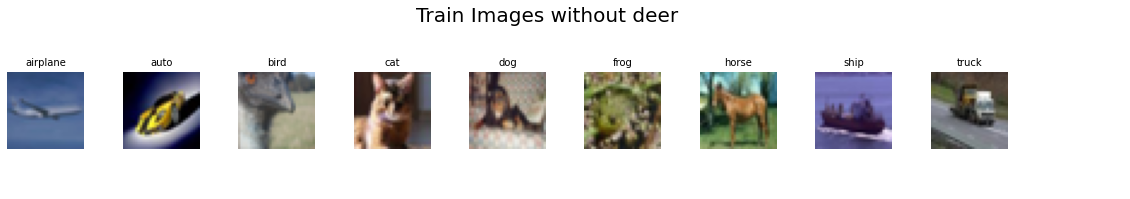

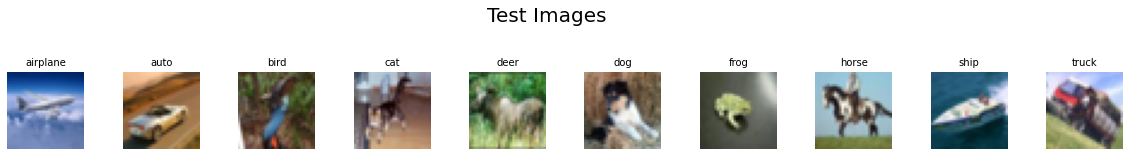

In [6]:
def plot_random_images(X,y,labels,suptitle):

    fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
    
    fig.subplots_adjust(hspace=0.5,wspace=0.5)
    
    # Check if data is already categorical
    if len(y[0]) > 1:
        y = np.argmax(y, axis=1)
    # Hide all axes first
    for a in axs:
        a.axis('off')
        #a.set_visible(False)  
    for i in np.unique(y):

        idx=np.random.choice(np.where(y==i)[0],1)
        
        img=X[idx]
        
        axs[i].imshow(img[0,:,:,:])
        axs[i].set_title(np.str(labels[i]),fontsize=10) 
        axs[i].set_aspect('equal')
        #plt.sca(axs[i])
        
    fig.suptitle(suptitle,fontsize=20)

plot_random_images(X_train,y_train, INCLUDED_LABELS,f'Train Images without {LABELS[EXCLUDED_LABELS_IDX[0]]}')
plot_random_images(X_test,y_test,LABELS,'Test Images')

# Create the Network

Now we create the fully connected neural network. Adapt the hyperparameters and see what happens.
E.g. if the number of hidden layer decreases, the network is not able to fit the dataset well. If you increase the number of hidden layers, the network will (maybe) fit better or overfit. There are some common rules to follow to find a good starting point for the number of hidden layers and the number of neurons per layer.

### The Number of Hidden Layers

| Num Hidden Layers       | Result        |  
| ----------------------- |:------------- | 
| None               | Only capable of representing linear separable functions or decisions.      |
| 1          | Can approximate any function that contains a continuous mapping from one finite space to another.      |
| 2          | Can represent an arbitrary decision boundary to arbitrary accuracy <br> with rational activation functions and can approximate any smooth mapping to any accuracy.     |
| >2          | Additional layers can learn complex representations (sort of automatic feature engineering) for layer layers.      |

### The Number of Neurons in the Hidden Layers

There are many rule-of-thumb methods for determining an acceptable number of neurons to use in the hidden layers, such as the following:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.
These three rules provide a starting point for you to consider the number of neurons. There is also some research about this topic: https://www.hindawi.com/journals/mpe/2013/425740/

I use some numbers which I tried in earlier notebooks

In [7]:
''' Specifiy the folder for loading an already saved model or for storing a new model'''
#SAVED_FOLDER='saved/ifar10_exclude_deer_avg_pooling'
SAVED_FOLDER='saved/cifar10_exclude_deer_no_pooling_stride_2x2'
#SAVED_FOLDER='saved/cifar10_exclude_deer_max_pooling'
ANALYTICAL = True # False: use approximation, True: use Gaussian_ReLU

tfk.backend.clear_session()
dropout=0.3
pooling='max' # possible values are [avg, max or '']. If pooling='' we will use a convolution stride of (2,2)
nn = net(X_train, y_train, 
         n_filter=[32,64,128],
         n_hidden=[],         # No additional hidden Dense layers
         dropout=dropout,
         pooling=pooling)

# Train and evaluate the neural network

Next we want to train the network and evaluate it against the test dataset.
Because training the convolutional network take some time, we want to reload the pretrained model if available.

In [8]:
def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Loading model saved/cifar10_exclude_deer_no_pooling_stride_2x2/model.hdf5... 
SavedModel file does not exist at: saved/cifar10_exclude_deer_no_pooling_stride_2x2/model.hdf5/{saved_model.pbtxt|saved_model.pb}
Start training new model and store it to saved/cifar10_exclude_deer_no_pooling_stride_2x2/model.hdf5... 
Train on 36000 samples, validate on 9000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/20
35968/36000 [============================>.] - ETA: 0s - loss: 1.6976 - accuracy: 0.3821
Epoch 00001: val_loss improved from inf to 1.36287, saving model to saved/cifar10_exclude_deer_no_pooling_stride_2x2\weights__epoch-01__val_loss-1.3629__val_acc-0.5269.hdf5
36000/36000 [==============================] - 34s 947us/sample - loss: 1.6973 - accuracy: 0.3822 - val_loss: 1.3629 - val_accuracy: 0.5269

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/20
35968/36000 [============================>.] - ETA: 0s - loss: 1.2934 - accu

35968/36000 [============================>.] - ETA: 0s - loss: 0.6577 - accuracy: 0.7667
Epoch 00017: val_loss did not improve from 0.63650
36000/36000 [==============================] - 33s 926us/sample - loss: 0.6576 - accuracy: 0.7667 - val_loss: 0.6378 - val_accuracy: 0.7800

Epoch 00018: LearningRateScheduler reducing learning rate to tf.Tensor(0.00049658533, shape=(), dtype=float32).
Epoch 18/20
35968/36000 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.7670
Epoch 00018: val_loss improved from 0.63650 to 0.62402, saving model to saved/cifar10_exclude_deer_no_pooling_stride_2x2\weights__epoch-18__val_loss-0.6240__val_acc-0.7883.hdf5
36000/36000 [==============================] - 35s 975us/sample - loss: 0.6527 - accuracy: 0.7670 - val_loss: 0.6240 - val_accuracy: 0.7883

Epoch 00019: LearningRateScheduler reducing learning rate to tf.Tensor(0.00044932897, shape=(), dtype=float32).
Epoch 19/20
35968/36000 [============================>.] - ETA: 0s - loss: 0

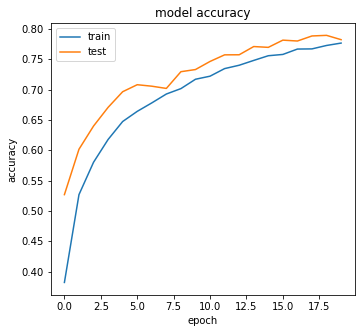

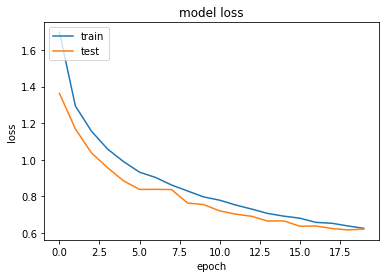


---- Model Summary ----
0 InputLayer (None, 32, 32, 3)
1 Conv2D (None, 32, 32, 32)
2 MaxPooling2D (None, 16, 16, 32)
3 Dropout (None, 16, 16, 32)
4 Conv2D (None, 16, 16, 64)
5 MaxPooling2D (None, 8, 8, 64)
6 Dropout (None, 8, 8, 64)
7 Conv2D (None, 8, 8, 128)
8 MaxPooling2D (None, 4, 4, 128)
9 Dropout (None, 4, 4, 128)
10 Flatten (None, 2048)
11 Dense (None, 9)

---- Model Evaluation (Included Data) ----
Test loss: 0.63491
Test accuracy: 0.77467

---- Model Evaluation (Excluded Data) ----
Test loss: 2.8595
Test accuracy: 0.078


In [9]:
''' Set the training hyperparameters (only used if the model could not be loaded)'''
BATCH_SIZE = 128
N_EPOCHS = 20

if  IN_COLAB:
    ''' Set the checkpoint path'''
    SAVED_FOLDER=REPO_NAME+'/notebooks/'+SAVED_FOLDER

try:
    ''' Try to load an already trained model'''
    print(f'Loading model {SAVED_FOLDER+"/model.hdf5"}... ')
    nn.model = tf.keras.models.load_model(SAVED_FOLDER+'/model.hdf5')
            
except OSError as e:
    print(e)
    print(f'Start training new model and store it to {SAVED_FOLDER+"/model.hdf5"}... ')
    os.mkdir(SAVED_FOLDER)
    
    hist = nn.train(BATCH_SIZE, N_EPOCHS, verbose=1, checkpoint_path=SAVED_FOLDER)
    plot_history(hist)
    
    ''' Save the new model '''
    nn.model.save(SAVED_FOLDER+'/model.hdf5')

    
''' Plot the class names of the network'''
print('\n---- Model Summary ----')
for i in range(len(nn.model.layers)):
    layer = nn.model.layers[i]
    print(i, layer.__class__.__name__, layer.output.shape)
    
''' Test include and exclude accuracy '''
# We need to change the shape of the test output to the desired network output
# e.g. on CIFAR, if we remove one number the shape is (N,9), thus the shape of the test set for evaluation must
# have the same shape. Use pd.get_dummies() to create categorical output

loss, accuracy  = nn.model.evaluate(x=X_test[test_include_idx],
                                    y=pd.get_dummies(y_test[test_include_idx][:,0]), 
                                    verbose=False)

print('\n---- Model Evaluation (Included Data) ----')
print(f'Test loss: {loss:.5}')
print(f'Test accuracy: {accuracy:.5}')
loss, accuracy  = nn.model.evaluate(x=X_test[test_exclude_idx],
                                        y=tf.keras.utils.to_categorical(y_test[test_exclude_idx],
                                                                        num_classes=y_train.shape[-1]), 
                                        verbose=False)
print('\n---- Model Evaluation (Excluded Data) ----')
print(f'Test loss: {loss:.5}')
print(f'Test accuracy: {accuracy:.5}')

# tf.keras.utils.plot_model(
#     nn.model, to_file='model.png', show_shapes=True, show_layer_names=False,
#     rankdir='TB', expand_nested=True, dpi=96
# )


## Prediction of MC-Dropout and EP

Now want to predict the testdataset with included and excluded images. For furhter processing we creating a dictionary to store all the information we need.

In [10]:
''' Get the prediction, standard deviation, RootMeanSquared Error and Runtime from Error Propagation Model'''
MC_SAMPLES=30
prediction_elements = ['pred','pred_label','std','entropy','nll','rt']

''' Create a list of prediction dictionaries'''
preds_dict = []

''' Single (Normal) Prediction'''
# preds_single_dict = dict(zip(prediction_elements, nn.predict(X_test,y_test)))
# preds_single_dict.update({'name':'single'})

''' MC-Dropout'''
preds_mc_dict = dict(zip(prediction_elements, nn.predict_mc(X_test, y_test,MC_SAMPLES)))
preds_mc_dict.update({'name':'MC'})
preds_mc_label =  np.array([INCLUDED_LABELS_IDX[np.argmax(preds_mc_dict['pred'],axis=1)[j]] for j in range(0,len(preds_mc_dict['pred']))])
preds_mc_dict.update({'pred_label':preds_mc_label})
preds_mc_dict.update({'true_label':y_test[:,0]})

''' ErrorProp'''
preds_ep_dict = dict(zip(prediction_elements, nn.predict_ep(X_test, y_test,use_gaussian_relu=ANALYTICAL,verbose=False)))
preds_ep_dict.update({'name':'EP'})                    
preds_ep_label =  np.array([INCLUDED_LABELS_IDX[np.argmax(preds_ep_dict['pred'],axis=1)[j]] for j in range(0,len(preds_ep_dict['pred']))]) 
preds_ep_dict.update({'pred_label':preds_ep_label})
preds_ep_dict.update({'true_label':y_test[:,0]})

''' Create a list of all dictionaries'''
#preds_dict.append(preds_single_dict)
preds_dict.append(preds_mc_dict)
preds_dict.append(preds_ep_dict)

# Compare the outputs for an included and excluded image 

We want to compare the outputs fo included and excluded images. Therefore we create some plots to show the network behaviour and output the uncertainty values for entropy, std, nll as well as the network runtime. We see that both networks (MC-Dropout and EP) predicts pretty well for test images that are part of the traing set. Images excluded from the training set (e.g. label **Deer**) lead to a higher uncertainty.

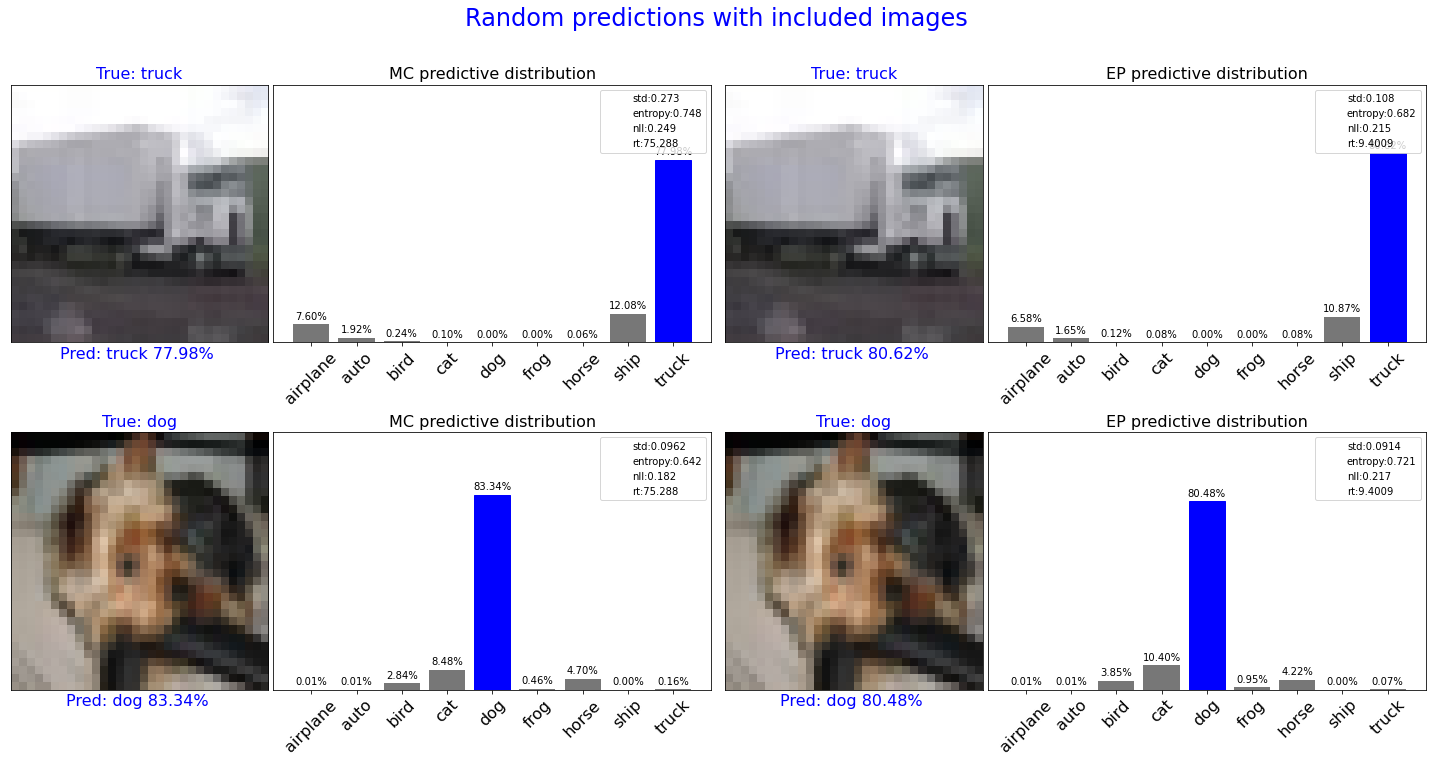

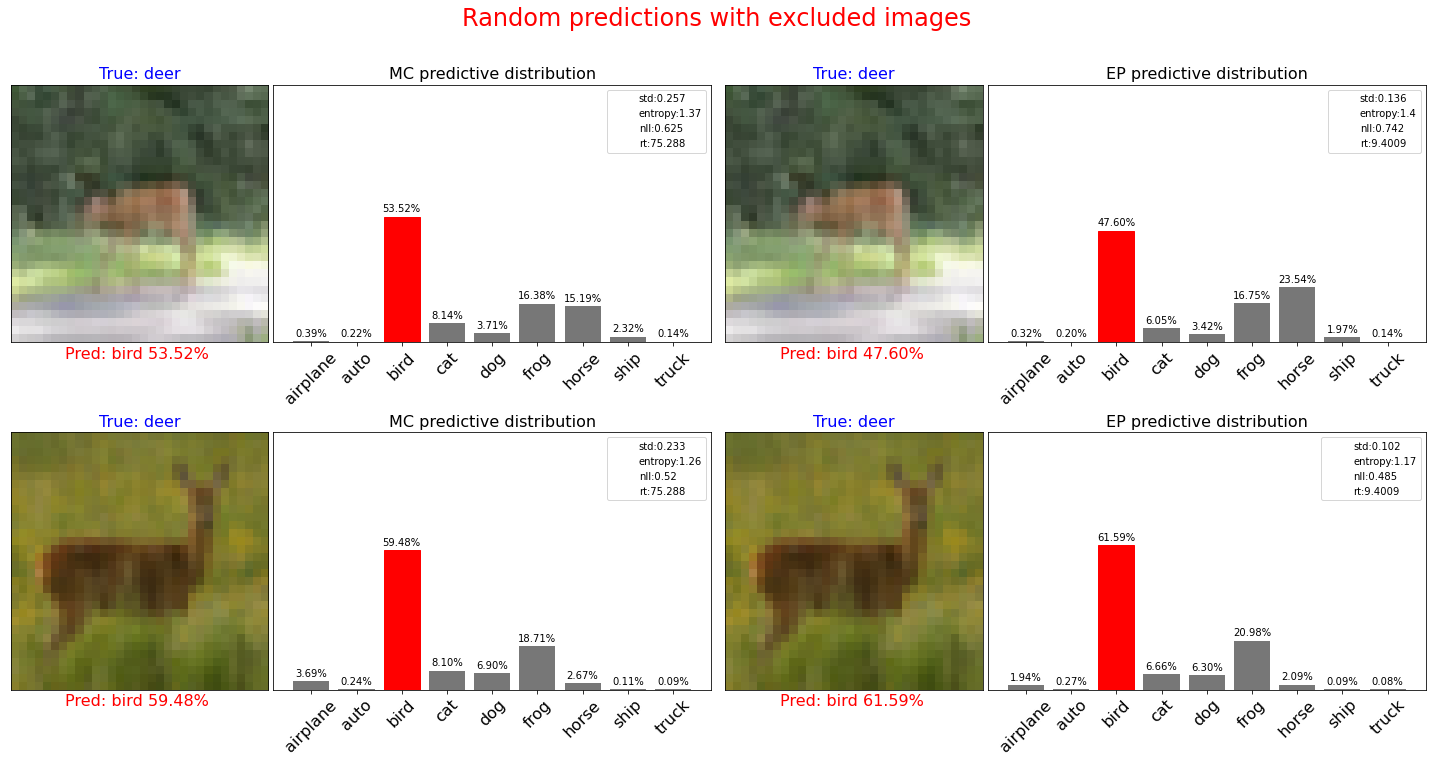

In [11]:
''' Plot an image with label name and confidence'''
def plot_image_with_bar(idx, preds, img, with_bar=True, subtitle=''):    
    from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
    
    
    def autolabel(rects,ax):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            perc = height*100
            ax.annotate('{:2.2f}%'.format(perc),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    '''Get the values'''
    predictions_array, true_label, img = preds['pred'][idx], preds['true_label'][idx], img[idx]
    
    # Get the current axis
    #f = plt.gcf()
    ax = plt.gca()

    font_size=16

    '''Plot the current image'''
    ax.imshow(img)

    predicted_label = np.argmax(predictions_array)

    if INCLUDED_LABELS_IDX[predicted_label] == LABELS_IDX[true_label]:
        color = 'blue'
    else:
        color = 'red'
    
    ax.set_title("True: {}".format(LABELS[true_label]),
                              color='blue', fontsize=font_size)
    
    ax.set_xlabel("Pred: {} {:2.2f}% ".format(INCLUDED_LABELS[predicted_label],
                                100*np.max(predictions_array)),
                                color=color, fontsize=font_size)
    
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ''' Create an divider and add the bar to the right'''   
    if with_bar:
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="170%", pad="2%")
        ax.grid(False)
        
        ''' Plot the distribution'''
        pred_plot = cax.bar(INCLUDED_LABELS, predictions_array, color="#777777")
        
        ''' Here we check the if the indices are correct'''        
        if INCLUDED_LABELS_IDX[predicted_label] == LABELS_IDX[true_label]:
            pred_plot[predicted_label].set_color('blue')
        else:
            pred_plot[predicted_label].set_color('red')       
        
        cax.set_xticks(np.arange(len(INCLUDED_LABELS)))
        cax.set_xticklabels(INCLUDED_LABELS,rotation=45,fontsize=font_size)
        cax.set_yticks([])
        cax.set_ylim(0.0,1.1)
        # add some additional information
        if subtitle != '':
            subtitle = '\n'+subtitle
        cax.set_title(str(preds["name"]).upper()+' predictive distribution'+subtitle,fontsize=font_size)
        cax.plot([],label=f'std:{preds["std"][idx]:.3}',color='white')
        cax.plot([],label=f'entropy:{preds["entropy"][idx]:.3}',color='white')
        cax.plot([],label=f'nll:{preds["nll"][idx]:.3}',color='white')
        cax.plot([],label=f'rt:{preds["rt"]:.5}',color='white')
        cax.legend()
        
        # put the y-values on top of the bar
        autolabel(pred_plot,cax) 
        
        
        
''' Generate some random samples indices'''
N_PLOTS=2
SUPTITLE_OFFSET=1.05
FIG_MUL=7
random_include_idx = np.random.choice(test_include_idx,N_PLOTS)

fig = plt.figure(figsize=(20,N_PLOTS*FIG_MUL),tight_layout=True,constrained_layout=False)
#fig.subplots_adjust(hspace=0.5,wspace=0.05)

fig.suptitle('Random predictions with included images',fontsize=24, color='blue',y=SUPTITLE_OFFSET)
for k, incl in enumerate(random_include_idx):
        for j in range(len(preds_dict)):   
            ax = fig.add_subplot(N_PLOTS+1,2,k*2+j+1)
            plot_image_with_bar(incl, preds_dict[j], X_test)


''' Check if elements from the dataset are excluded'''
if len(test_exclude_idx) > 0:        
    fig = plt.figure(figsize=(20,N_PLOTS*FIG_MUL),tight_layout=True,constrained_layout=False)
    #fig.subplots_adjust(hspace=0.5,wspace=0.05)
    fig.suptitle('Random predictions with excluded images',fontsize=24, color='red',y=SUPTITLE_OFFSET)
    
    random_exclude_idx = np.random.choice(test_exclude_idx,N_PLOTS)
    for k, excl in enumerate(random_exclude_idx):
        for j in range(len(preds_dict)):   
            ax = fig.add_subplot(N_PLOTS+1,2,k*2+j+1)
            plot_image_with_bar(excl, preds_dict[j], X_test)

# Compare the outputs for correct and incorrect classified images

Besides the evaluation of included and excluded images, we want to get a feeling about the network behaves of missclassifications. More specifically, how the network behaves if the test images are part of the training set but has a missclassification.

MC classified correct: 6984
MC classified incorrect: 3016
EP classified correct: 6972
EP classified incorrect: 3028


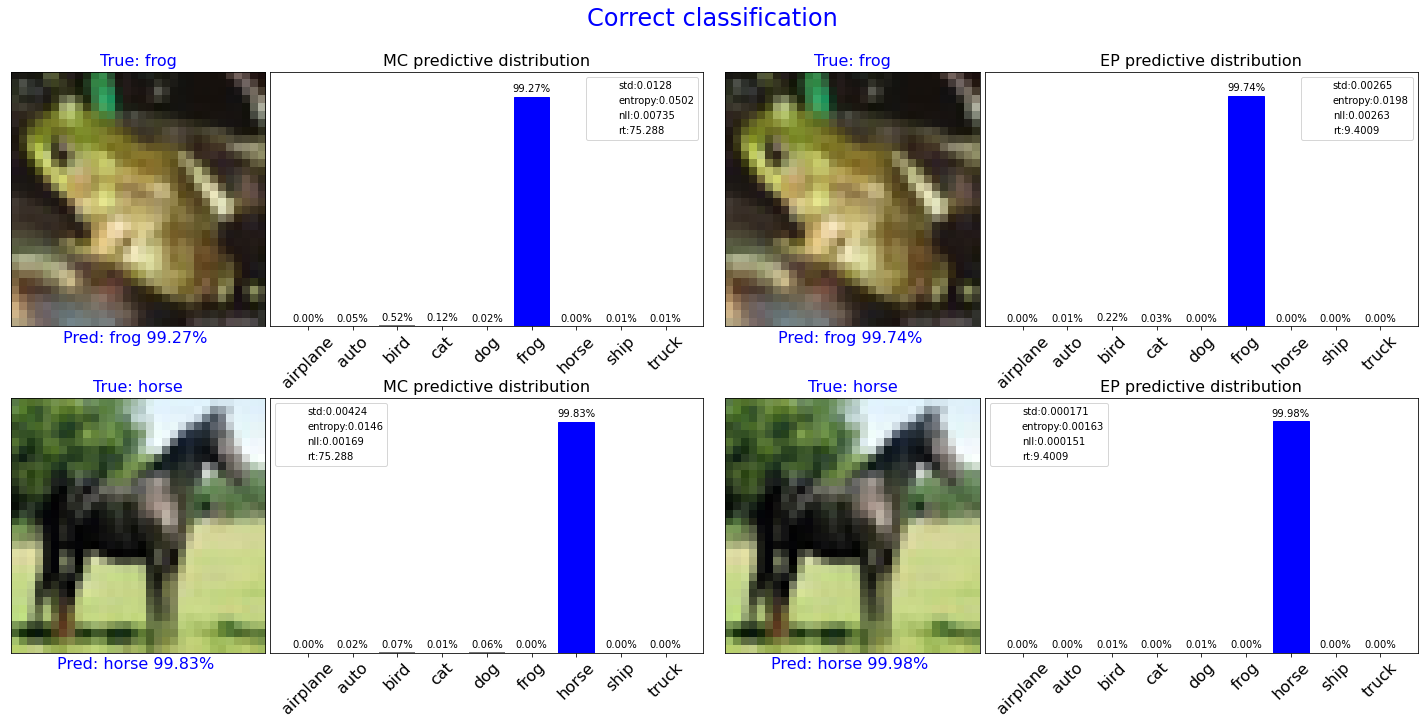

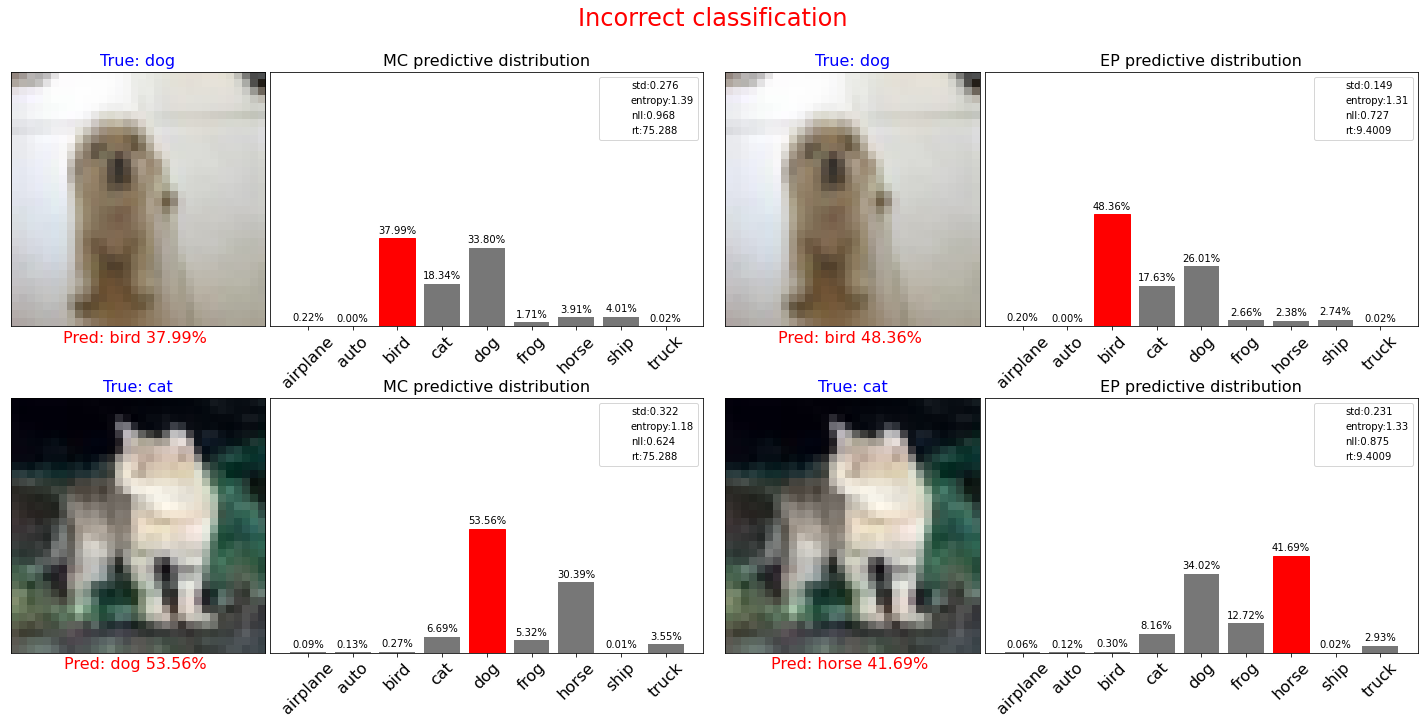

In [12]:
corr = []
incorr = []
for j in range(len(preds_dict)):

    ''' Set some variables here'''
    name = preds_dict[j]['name']
    y_pred = preds_dict[j]['pred']
    y_pred_label = preds_dict[j]['pred_label']
    y_test_label = preds_dict[j]['true_label']
    std = preds_dict[j]['std']
    nll = preds_dict[j]['nll']
    entropy = preds_dict[j]['entropy']
    rt = preds_dict[j]['rt']

    '''see which we predicted correctly and which not'''
    corr_ind = np.nonzero(y_pred_label == y_test_label)[0]
    incorr_ind = np.nonzero(y_pred_label != y_test_label)[0]
    

    print(f'{name} classified correct: {len(corr_ind)}')
    print(f'{name} classified incorrect: {len(incorr_ind)}')
    
    ''' Collect the correct and incorrect indicies of all models'''
    corr.append(corr_ind)
    incorr.append(incorr_ind)

''' Get the unique indices of both MC and EP'''
correct_indices =list(set(corr[0]).intersection(corr[1]))
incorrect_indices=list(set(incorr[0]).intersection(incorr[1]))
# remove all indices that are already in excluded indices
incorrect_indices = list(set(incorrect_indices)-set(test_exclude_idx))


''' Generate some random samples indices'''
N_PLOTS=2
SUPTITLE_OFFSET=1.05
FIG_MUL=6.5

''' Correct classification'''
fig = plt.figure(figsize=(20,N_PLOTS*FIG_MUL),tight_layout=True,constrained_layout=False)
fig.suptitle('Correct classification',fontsize=24, color='blue',y=SUPTITLE_OFFSET)

for k, cc in enumerate(np.random.choice(correct_indices,N_PLOTS)):
        for j in range(len(preds_dict)):   
            ax = fig.add_subplot(N_PLOTS+1,2,k*2+j+1)
            plot_image_with_bar(cc, preds_dict[j], X_test)

            
''' Incorrect classification'''
fig = plt.figure(figsize=(20,N_PLOTS*FIG_MUL),tight_layout=True,constrained_layout=False)
fig.suptitle('Incorrect classification',fontsize=24, color='red',y=SUPTITLE_OFFSET)

for k, ic in enumerate(np.random.choice(incorrect_indices,N_PLOTS)):
        for j in range(len(preds_dict)):   
            ax = fig.add_subplot(N_PLOTS+1,2,k*2+j+1)
            plot_image_with_bar(ic, preds_dict[j], X_test)

## Plot Confusion matrix of all features within the Test Dataset

With the help of the confusion matrix we get an overview of the above image plots. The confusion matrix shows us which labels the network predict.

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, target_names,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = target_names[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    accuracy = accuracy_score(y_true, y_pred)
    misclass = 1. - accuracy
    #print(cm)
    #print(classification_report(y_true, y_pred, target_names=target_names))
    #print(precision_recall_fscore_support(y_true, y_pred, average=None,labels=target_names))

    fig, ax = plt.subplots(figsize=(16, 6), dpi=100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title+'\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),
           ylabel='True label',
           xlabel='Predicted label')
        

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
Confusion matrix, without normalization


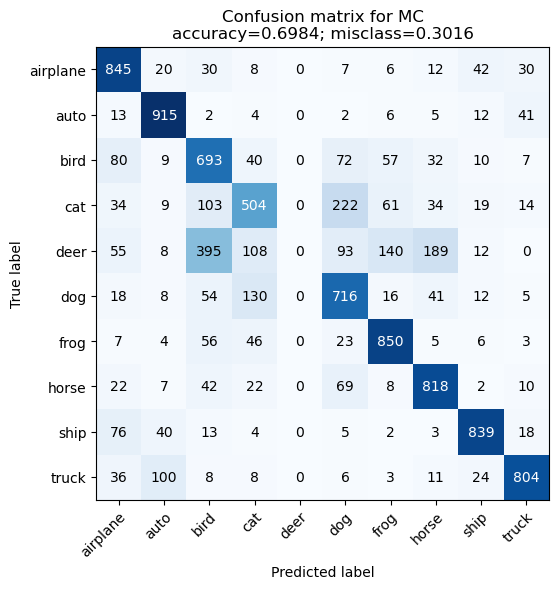

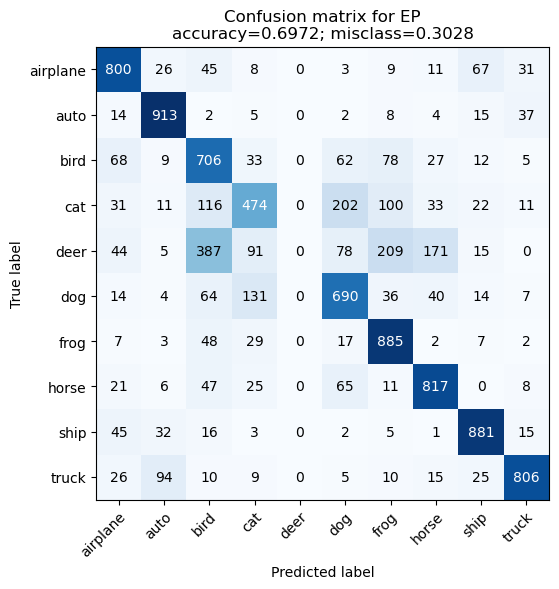

In [14]:
for j in range(len(preds_dict)):

    ''' Set some variables here'''
    name = preds_dict[j]['name']
    y_pred = preds_dict[j]['pred']
    y_pred_label = preds_dict[j]['pred_label']
    y_test_label = preds_dict[j]['true_label']
    std = preds_dict[j]['std']
    nll = preds_dict[j]['nll']
    entropy = preds_dict[j]['entropy']
    rt = preds_dict[j]['rt']
    
    ''' Plot the confusion matrix'''
    plot_confusion_matrix(y_test_label, 
                          y_pred_label, 
                          target_names=np.array(LABELS),
                          normalize    = False,
                          title='Confusion matrix for '+name)  
plt.show()

We see that the excluded label **Deer** is predicted most often as another animal like **Horse or Bird**. 
If we take a deeper look into the network, we will see that the featues of these labels are quite equal to the **Deer** with respect to shape and color.

# Get the predicted labels for excluded classes

Below we list the predicted labes (same as the confusion matrix) in another plot. This plot is just for having a better overview.

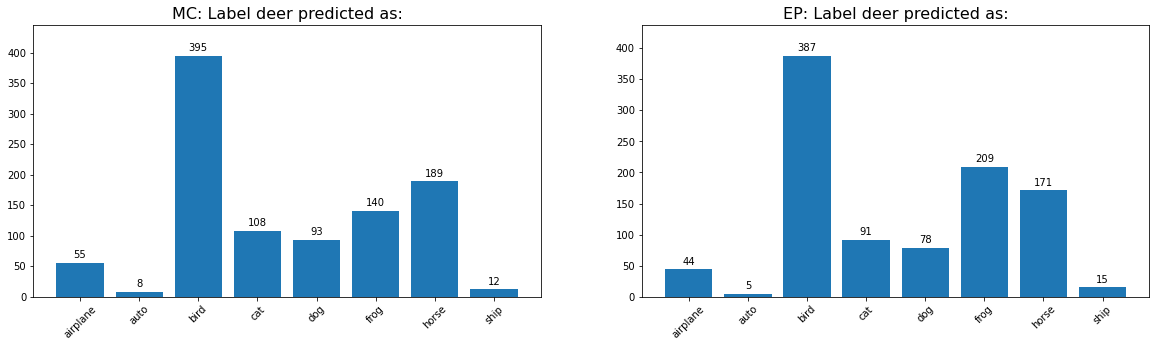

In [15]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
def label_bar(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    
if EXCLUDED_LABELS_IDX:
    labels = EXCLUDED_LABELS_IDX
else:
    labels = INCLUDED_LABELS_IDX
    
fig = plt.figure(figsize=(20,5*len(labels)))
fig.subplots_adjust(hspace=0.5,wspace=0.2)


for j in range(len(preds_dict)):

    ''' Set some variables here'''
    name = preds_dict[j]['name']
    y_pred = preds_dict[j]['pred']
    y_pred_label = preds_dict[j]['pred_label']
    y_test_label = preds_dict[j]['true_label']
    std = preds_dict[j]['std']
    nll = preds_dict[j]['nll']
    entropy = preds_dict[j]['entropy']
    rt = preds_dict[j]['rt']

    for k,ex in enumerate(labels):
        idx = get_excluded_idx(y_test,ex)
        ax = plt.subplot(len(labels),2,(j*len(labels))+k+1)
        
        ''' Important: Get only the labels that are part of the prediction of the excluded label'''
        rect = plt.bar([LABELS[i] for i in np.unique(y_pred_label[idx],return_counts=True)[0]],
                       np.unique(y_pred_label[idx],return_counts=True)[1])
        ax.set_title(f'{name}: Label {LABELS[ex]} predicted as:',fontsize=16)
        ax.set_ylim([0,max([r.get_height() for r in rect])+50])
        plt.xticks(rotation=45)
        label_bar(rect)

# Plot histogram of NLL, Std and Entropy for (Ex)-Included labels

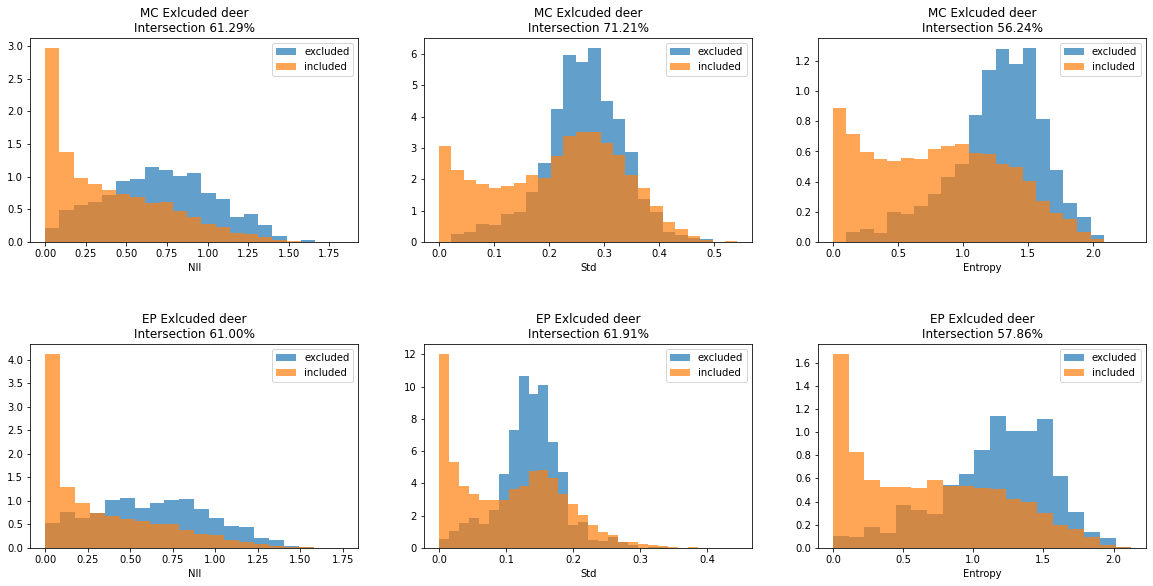

In [16]:
def return_intersection(hist_1, hist_2):
    #https://mpatacchiola.github.io/blog/2016/11/12/the-simplest-classifier-histogram-intersection.html
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

def plot_histogram(idx, values, title, bins=None,xlabel='', xlim=None,ylim=None,legends=['excluded','included']):
        
    if len(idx) > 1:
        
        if bins is None:
            ''' Calculate the bin widths'''    
            binwidth = 0.5*(((1/np.cbrt(len(values[idx[0]])))*np.std(values[idx[0]]) + 
                             (1/np.cbrt(len(values[idx[1]])))*np.std(values[idx[1]]))*3.49)
            xymax = np.max([np.max(np.fabs(values[idx[0]])), np.max(np.fabs(values[idx[1]]))])
            lim = (int(xymax/binwidth) + 1)*binwidth
            bins = np.arange(0, lim + binwidth, binwidth)
            
            values_ex, bins_ex, patches_ex = plt.hist(values[idx[0]],bins=bins, density=True, alpha = 0.7)
            values_in, bins_in, patches_in = plt.hist(values[idx[1]],bins=bins, density=True, alpha = 0.7)
        else:     
            ''' Calculate the ranges between the histogram data'''
            ranges = [np.floor(np.min([np.amin(values[idx[0]]),np.amin(values[idx[1]])])),
                      np.ceil(np.max([np.amax(values[idx[0]]),np.amax(values[idx[1]])]))]
            values_ex, bins_ex, patches_ex = plt.hist(values[idx[0]],bins=bins, 
                                                      range=ranges, density=True, alpha = 0.7)
            values_in, bins_in, patches_in = plt.hist(values[idx[1]],bins=bins,  
                                                      range=ranges, density=True, alpha = 0.7)

        #plt.ylim(0,min([max(bins_ex),max(bins_in)]))

        ''' Calculate the intesection of the to histograms'''
        intersection = return_intersection(values_in,values_ex)*100

        plt.title(f'{title}\nIntersection {intersection:2.2f}%')
    else:
        values_ex, bins_ex, patches_ex = plt.hist(values[idx[0]],bins=bins, density=True,alpha = 0.7)
        plt.title(f'{title}')
        
    plt.legend(legends)
    #plt.legend(['excluded'])
    plt.xlabel(f'{xlabel}')
    if xlim != None:
        plt.xlim(xlim)
    if ylim != None:
        plt.ylim(ylim)



if EXCLUDED_LABELS_IDX:
    labels = EXCLUDED_LABELS_IDX
else:
    labels = INCLUDED_LABELS_IDX

''' Create the figure size dynamically'''
fig = plt.figure(figsize=(20,15*len(labels)))    
fig.subplots_adjust(hspace=0.5,wspace=0.2)

''' Set the number of bins, if None, the bins will be calulated'''
n_bins = None

for j in range(len(preds_dict)):

    ''' Set some variables here'''
    name = preds_dict[j]['name']
    y_pred = preds_dict[j]['pred']
    y_pred_label = preds_dict[j]['pred_label']
    y_test_label = preds_dict[j]['true_label']
    std = preds_dict[j]['std']
    nll = preds_dict[j]['nll']
    entropy = preds_dict[j]['entropy']
    rt = preds_dict[j]['rt']

    if EXCLUDED_LABELS_IDX:
        for k,ex in enumerate(labels):
            idx_ex = get_excluded_idx(y_test,ex)
            idx_in = get_included_idx(y_test,ex)

            ax = plt.subplot(len(labels)*3,3,(j*len(labels)*3)+k*3+1)
            plot_histogram(idx=[idx_ex,idx_in], values=nll, title=name+' Exlcuded ' +LABELS[ex], bins=n_bins,xlabel="Nll")

            ax = plt.subplot(len(labels)*3,3,(j*len(labels)*3)+k*3+2)
            plot_histogram(idx=[idx_ex,idx_in], values=std, title=name+' Exlcuded ' +LABELS[ex], bins=n_bins,xlabel="Std")

            ax = plt.subplot(len(labels)*3,3,(j*len(labels)*3)+k*3+3)
            plot_histogram(idx=[idx_ex,idx_in], values=entropy, title=name+' Exlcuded ' +LABELS[ex], bins=n_bins,xlabel="Entropy")
    else:   
        
        for k,ex in enumerate(labels):
            idx = get_excluded_idx(y_test,ex) # Call get_excluded_idx here to get the indices of the image you want

            ax = plt.subplot(len(labels)*3,3,(j*len(labels)*3)+k*3+1)
            plot_histogram(idx=[idx], values=nll, title=name+' Included ' +LABELS[ex], bins=n_bins,xlabel="Nll",legends=['Included'])

            ax = plt.subplot(len(labels)*3,3,(j*len(labels)*3)+k*3+2)
            plot_histogram(idx=[idx], values=std, title=name+' Included ' +LABELS[ex], bins=n_bins,xlabel="Std",legends=['Included'])

            ax = plt.subplot(len(labels)*3,3,(j*len(labels)*3)+k*3+3)
            plot_histogram(idx=[idx], values=entropy, title=name+' Included ' +LABELS[ex], bins=n_bins,xlabel="Entropy",legends=['Included'])
        
#     for k,ex in enumerate(EXCLUDED_LABELS_IDX):
#         idx = get_excluded_idx(y_test,ex)
#         plt.subplot(len(preds_dict),3,(j*3)+1)
#         plot_histogram(nll, name, "Nll", [-0.1,3])
#         plt.subplot(len(preds_dict),3,(j*3)+2)
#         plot_histogram(std, name, "Std", [-0.1,1.0])
#         plt.subplot(len(preds_dict),3,(j*3)+3)
#         plot_histogram(std, name, "Entropy", [-0.1,2.5])


As we can see in the above pictures, the exluded label have a higher uncertainty (broad histogram) than the included ones (all without the exluded labels). For the included labels the histogramm shows that the values are all around zero.

We also see that intersection area of the histograms between MC-Dropout and ErrorProp is quite the same for NLL and Entropy. 

For Std the values differ. There is a higher spread in MC-Dropout for included labels (labels that are learned during the testing) than in ErrorProp. Further the standard deviation (uncertainty) values are smaller in EP than in MC Dropout

# Plot histogram of NLL, Std and Entropy for (In)-Correct predicted labels

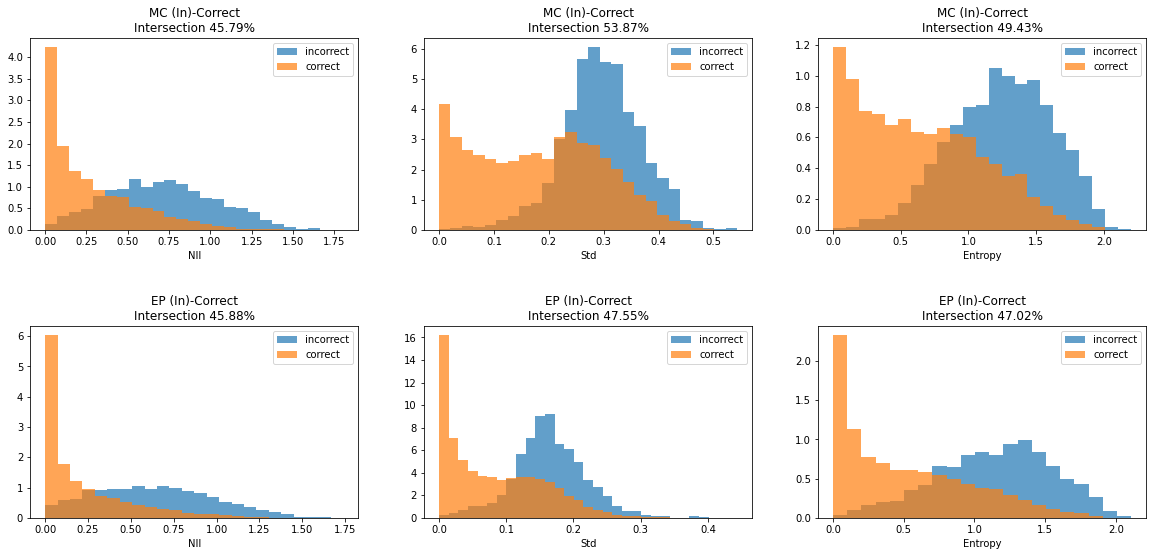

In [17]:
fig = plt.figure(figsize=(20,30))
fig.subplots_adjust(hspace=0.5,wspace=0.2)

for j in range(len(preds_dict)):

    ''' Set some variables here'''
    name = preds_dict[j]['name']
    y_pred = preds_dict[j]['pred']
    y_pred_label = preds_dict[j]['pred_label']
    y_test_label = preds_dict[j]['true_label']
    std = preds_dict[j]['std']
    nll = preds_dict[j]['nll']
    entropy = preds_dict[j]['entropy']
    rt = preds_dict[j]['rt']
 
    ax = fig.add_subplot(6,3,(j*3)+1)
    plot_histogram(idx=[incorrect_indices,correct_indices], 
                   values=nll, 
                   bins=n_bins,
                   title=name+' (In)-Correct', 
                   xlabel="Nll", legends=['incorrect','correct'])

    ax = fig.add_subplot(6,3,(j*3)+2)
    plot_histogram(idx=[incorrect_indices,correct_indices], 
                   values=std, 
                   bins=n_bins,
                   title=name+' (In)-Correct', 
                   xlabel="Std", legends=['incorrect','correct'])

    ax = fig.add_subplot(6,3,(j*3)+3)
    plot_histogram(idx=[incorrect_indices,correct_indices], 
                   values=entropy, 
                   bins=n_bins,
                   title=name+' (In)-Correct', 
                   xlabel="Entropy", legends=['incorrect','correct'])

# Plot Excluded Images with highest and lowest uncertainty

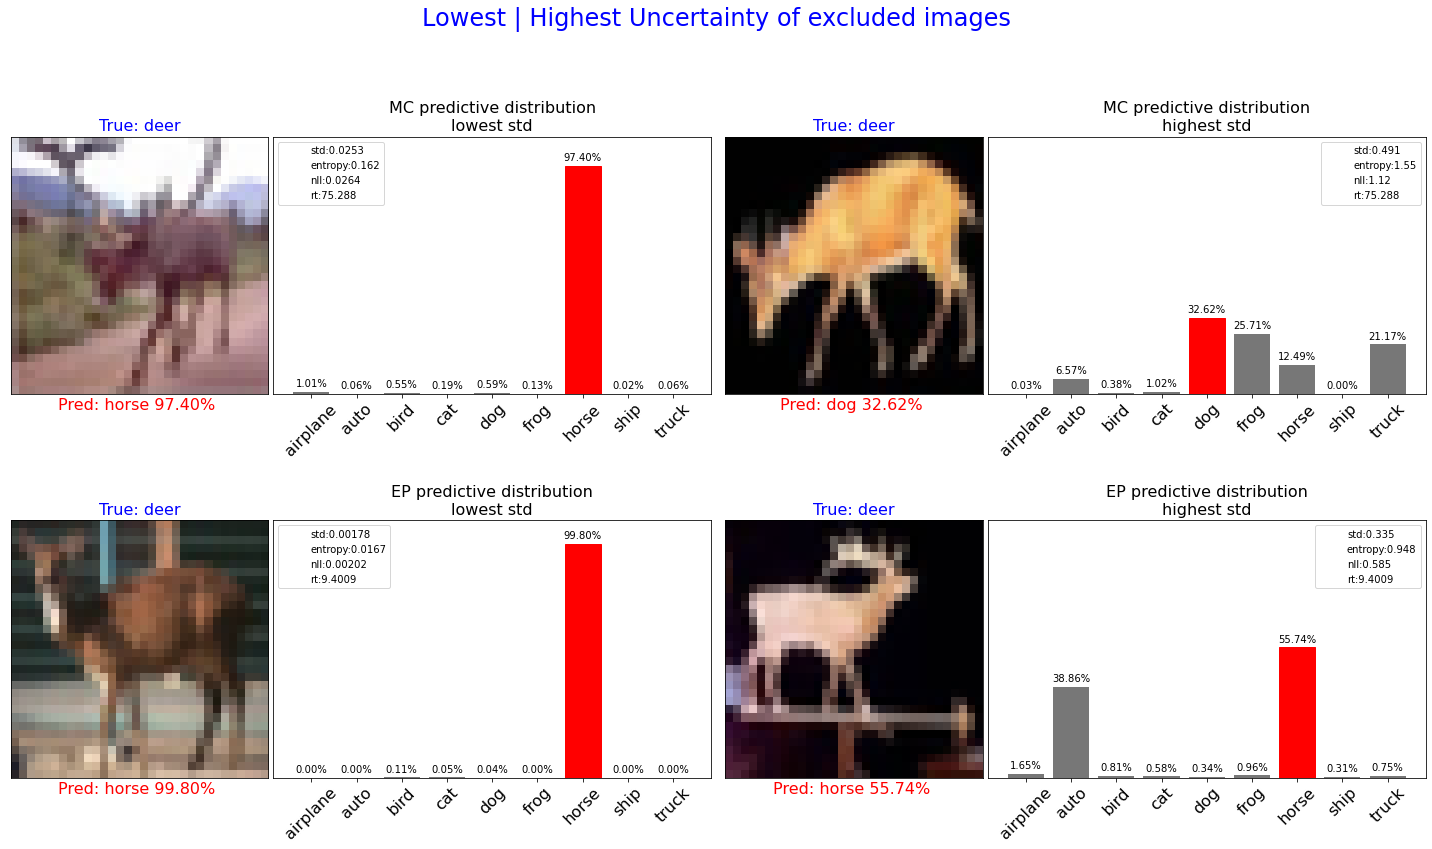

In [18]:
#min_idx = np.argmin(std[idx_ex])
k_elements = 1 # k-elements of the highest and lowest
N_PLOTS=3
SUPTITLE_OFFSET=1.05
FIG_MUL=7

labels = EXCLUDED_LABELS_IDX

''' Plot the results for lowest uncertainty'''
fig = plt.figure(figsize=(20,N_PLOTS*FIG_MUL),tight_layout=True,constrained_layout=False)
fig.suptitle('Lowest | Highest Uncertainty of excluded images',fontsize=24, color='blue',y=SUPTITLE_OFFSET)
for i,ex in enumerate(labels):
    ''' 1. Get all idexes that correspond to excluded number e.g. Zero'''
    idx_ex = get_excluded_idx(y_test,ex)
    #idx_in = get_included_idx(y_test_label,ex)
    
    ''' 2. Get the uncertainty from the Model'''
    for j in range(len(preds_dict)):
        ''' Set some variables here'''
        name = preds_dict[j]['name']
        y_pred = preds_dict[j]['pred']
        y_pred_label = preds_dict[j]['pred_label']
        y_test_label = preds_dict[j]['true_label']
        std = preds_dict[j]['std']
        nll = preds_dict[j]['nll']
        entropy = preds_dict[j]['entropy']
        rt = preds_dict[j]['rt']

        ''' 3. Get highest and lowest uncertainty indices'''
        #lowest_unc =np.argpartition(std[idx_ex], k_elements)
        #highest_unc =np.argpartition(std[idx_ex], -k_elements)
        lowest_unc = (std[idx_ex]).argsort()[:k_elements]
        highest_unc = (-std[idx_ex]).argsort()[:k_elements]

        for k, u in enumerate(zip(lowest_unc, highest_unc)):
                l = u[0] # index of lowest uncertainty
                h = u[1] # index of highest uncertainty
                spidx = j*2*len(lowest_unc)+k*2
                #print(j*2+k+1)
                
                ax = fig.add_subplot(4,2,spidx+1)
                #ax.set_title('asdfasdf')
                plot_image_with_bar(idx_ex[l], preds_dict[j], X_test,subtitle='lowest std')
                ax = fig.add_subplot(4,2,spidx+2)
                plot_image_with_bar(idx_ex[h], preds_dict[j], X_test,subtitle='highest std')

# Accuracy filtered by uncertainty

The following experiment shows the accuracy of MC-Dropout vs. EP filtered by the underlying uncertainties `entropy`, `nll` and `std`. 

In [19]:
def unc_filtered_acc(preds_dictionary, u_type='std',k_elements=1000,enable_print=False): 
    
    '''Needed variables'''
    unc_type_vals = preds_dictionary[u_type] # std, entropy or nll
    true_labels = preds_dictionary['true_label']
    pred_labels = preds_dictionary['pred_label'] # Correct mapping to the included indices done 
        
    ''' Indices of k_elements sorted'''
    low_unc_idx = (unc_type_vals).argsort()[:k_elements]   
    
    ''' Calculate the metric based on the sorted indices'''
    acc = tf.keras.metrics.Accuracy()
    acc.update_state(true_labels[low_unc_idx],pred_labels[low_unc_idx])
    
    if enable_print:
        print(f'{preds_dictionary["name"]}: Accuracy filtered={acc.result().numpy():.3f}\
        (k_elements={k_elements}, Filter={u_type})')

    ''' Return the measured accuracy'''
    return acc.result().numpy()


def unc_filtered_acc_loop(preds_dictionary, u_type='std',k_elements=1000): 
    
    '''Needed variables'''
    unc_type_vals = preds_dictionary[u_type] # std, entropy or nll
    true_labels = preds_dictionary['true_label']
    pred_labels = preds_dictionary['pred_label'] # Correct mapping to the included indices done    
    
    ''' Indices of k_elements sorted'''
    low_unc_idx = (unc_type_vals).argsort()[:k_elements]   
    
    ''' Calculate the metric based on the sorted indices'''
    acc = tf.keras.metrics.Accuracy()
    result = np.zeros(len(low_unc_idx))

    for j,idx in enumerate(low_unc_idx):
        acc.update_state(true_labels[idx],pred_labels[idx])
        result[j] = acc.result().numpy()

    ''' Return the measured accuracy'''
    return result

def plot_additional_infos(mc_accs,ep_accs):
    ''' Do some additional fancy plots'''
    # Both calculations are the same
    diff = np.abs(np.subtract(mc_accs,ep_accs))
    #diff = np.abs(np.diff(np.array([mc_accs, ep_accs]), axis=0))[0]
    maxpoint = np.argmax(diff)

    plt.vlines(x=maxpoint,ymin=mc_accs[maxpoint], ymax=ep_accs[maxpoint], 
               color='green',label=f'max diff at {maxpoint} ({diff[maxpoint]:.4f})')
    
    plt.text(x=maxpoint, y=((mc_accs[maxpoint] + ep_accs[maxpoint])/2) , 
             s=f'{diff[maxpoint]:.4f}', rotation=0, verticalalignment='center',color='green')
    
    # plt.vlines(x=maxpoint,ymin=diff[maxpoint], 
    #            ymax=ep_results[maxpoint], color='green',linestyles='dashed')
    # plt.plot(diff,label=f'diff at {maxpoint}')

    # Add extra tick to x axis (looks weird if points close by)
    #plt.xticks(list(plt.xticks()[0]) + [maxpoint])

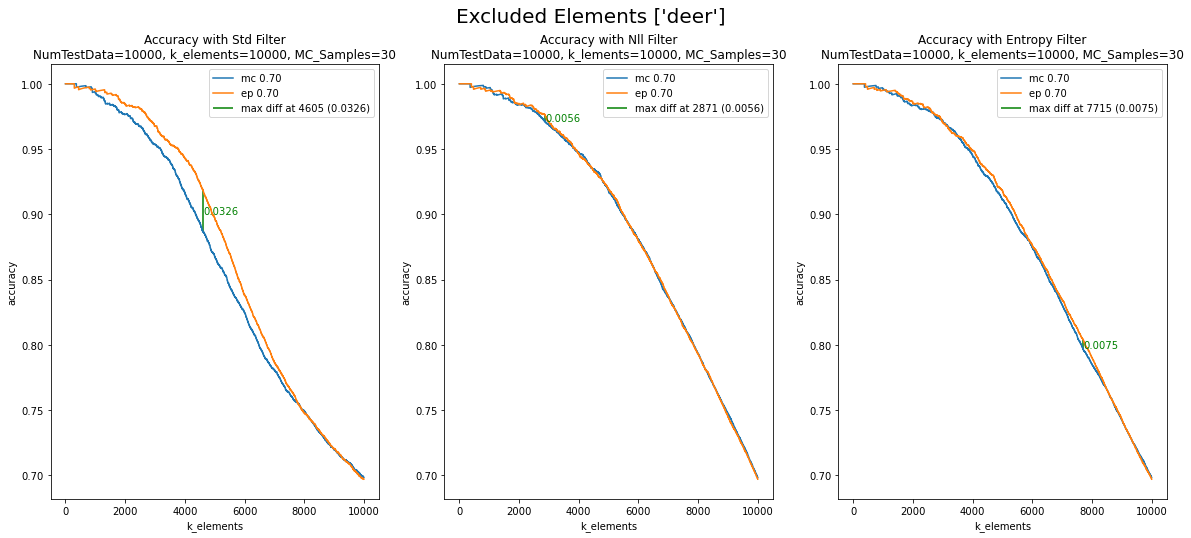

In [20]:
k_elements = 10000
plt.figure(figsize=(20,8))

##########################
plt.subplot(1,3,1)
plt.suptitle(f"Excluded Elements {EXCLUDED_LABELS}\n",fontsize=20)

mc_results = unc_filtered_acc_loop(preds_dict[0],'std',k_elements)
ep_results = unc_filtered_acc_loop(preds_dict[1],'std',k_elements)

'''Plot the results'''
plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}')
plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}')

'''Plot some additional stuff'''
plot_additional_infos(mc_results,ep_results)

plt.title(f'Accuracy with Std Filter\nNumTestData={len(y_test)}, k_elements={k_elements}, MC_Samples={MC_SAMPLES}')
plt.xlabel('k_elements')
plt.ylabel("accuracy")
plt.legend()

##########################
plt.subplot(1,3,2)

mc_results = unc_filtered_acc_loop(preds_dict[0],'nll',k_elements)
ep_results = unc_filtered_acc_loop(preds_dict[1],'nll',k_elements)

'''Plot the results'''
plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}')
plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}')

'''Plot some additional stuff'''
plot_additional_infos(mc_results,ep_results)

plt.title(f'Accuracy with Nll Filter\nNumTestData={len(y_test)}, k_lements={k_elements}, MC_Samples={MC_SAMPLES}')
plt.xlabel('k_elements')
plt.ylabel("accuracy")
plt.legend()

##########################
plt.subplot(1,3,3)

mc_results = unc_filtered_acc_loop(preds_dict[0],'entropy',k_elements)
ep_results = unc_filtered_acc_loop(preds_dict[1],'entropy',k_elements)

'''Plot the results'''
plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}')
plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}')

'''Plot some additional stuff'''
plot_additional_infos(mc_results,ep_results)

plt.title(f'Accuracy with Entropy Filter\nNumTestData={len(y_test)}, k_elements={k_elements}, MC_Samples={MC_SAMPLES}')
plt.xlabel('k_elements')
plt.ylabel("accuracy")
plt.legend()

plt.show()

# Mean Squared Error calculation

In [21]:
from sklearn.metrics import mean_squared_error

mse_std_mc_vs_ep = mean_squared_error(preds_dict[0]['std'], preds_dict[1]['std'])
mse_nll_mc_vs_ep = mean_squared_error(preds_dict[0]['nll'], preds_dict[1]['nll'])
mse_entropy_mc_vs_ep = mean_squared_error(preds_dict[0]['entropy'], preds_dict[1]['entropy'])

mse_pred_mc_vs_ep = mean_squared_error(preds_dict[0]['pred_label'], preds_dict[1]['pred_label'])
mse_mc_pred_vs_true = mean_squared_error(preds_dict[0]['pred_label'], preds_dict[0]['true_label'])
mse_ep_pred_vs_true = mean_squared_error(preds_dict[1]['pred_label'], preds_dict[1]['true_label'])


print(f'Std: MC vs EP : {mse_std_mc_vs_ep}')
print(f'Nll: MC vs EP : {mse_nll_mc_vs_ep}')
print(f'Entropy: MC vs EP : {mse_entropy_mc_vs_ep}')

print(f'Pred: MC vs EP : {mse_pred_mc_vs_ep}')
print(f'Pred: MC vs True : {mse_mc_pred_vs_true}')
print(f'Pred: EP vs True : {mse_ep_pred_vs_true}')

Std: MC vs EP : 0.015829969197511673
Nll: MC vs EP : 0.020327100530266762
Entropy: MC vs EP : 0.0343399739493977
Pred: MC vs EP : 1.4937
Pred: MC vs True : 4.6341
Pred: EP vs True : 4.454


# Runtime measurements

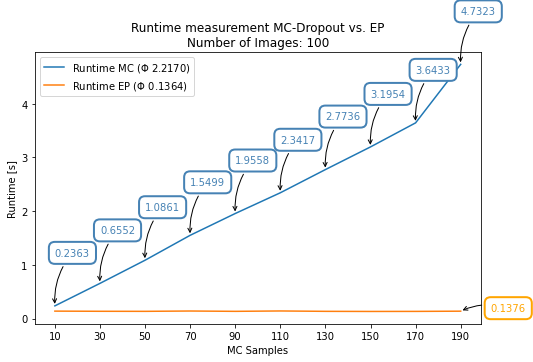

In [22]:
''' Set the Range of MC-Samples'''
mc_samples = np.arange(10,200,20)

runtimes_mc = []
runtimes_ep = []

''' Choose N random images for Runtime Calculation'''
idx = np.random.choice(X_test.shape[0],100,replace=False)

for i,mc in enumerate(mc_samples):

    ''' MC-Dropout'''
    runtimes_mc.append(dict(zip(prediction_elements, nn.predict_mc(X_test[idx], y_test[idx], mc)))['rt'])

    ''' ErrorProp'''
    runtimes_ep.append(dict(zip(prediction_elements, nn.predict_ep(X_test[idx], y_test[idx],
                                                                   use_gaussian_relu=ANALYTICAL)))['rt'])

#bbox_args = dict(boxstyle="round", fc="w")
bbox_args = dict(boxstyle="round,pad=0.6", fc="w", ec="steelblue",lw=2)
arrow_args = dict(arrowstyle="->",connectionstyle="arc3,rad=.2")
x_ticks = np.arange(0,len(mc_samples))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(runtimes_mc,label=f'Runtime MC ($\Phi$ {np.mean(runtimes_mc):.4f})')
for i, txt in enumerate(runtimes_mc):
    ax.annotate(s="{:.4f}".format(txt), 
                xy=(x_ticks[i],runtimes_mc[i]), 
                xycoords='data',
                xytext=(-0, 50),
                textcoords='offset points',
                bbox=bbox_args,
                arrowprops=arrow_args,
                color='steelblue')

ax.plot(runtimes_ep,label=f'Runtime EP ($\Phi$ {np.mean(runtimes_ep):.4f})')
bbox_args.update(ec="orange")
ax.annotate(s="{:.4f}".format(runtimes_ep[-1]), 
                xy=(x_ticks[-1],runtimes_ep[-1]), 
                xycoords='data',
                xytext=(30, 0),
                textcoords='offset points',
                bbox=bbox_args,
                arrowprops=arrow_args,
                color='orange')

ax.set_xticks(x_ticks)
ax.set_xticklabels(mc_samples)
ax.set_ylabel('Runtime [s]')
ax.set_xlabel('MC Samples')
plt.title(f'Runtime measurement MC-Dropout vs. EP\nNumber of Images: {len(idx)}')
plt.legend()
plt.show()

# References
* [Dataset Search](https://datasetsearch.research.google.com/)
* [Tensorflow Datasets](https://www.tensorflow.org/datasets)
* [List of all Datasets included in Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)
* [1. Useful Metrics](https://towardsdatascience.com/20-popular-machine-learning-metrics-part-1-classification-regression-evaluation-metrics-1ca3e282a2ce)
* [2. Useful Metrics](https://datascience.stackexchange.com/questions/26854/what-are-useful-evaluation-metrics-used-in-machine-learning)

























